# 기본환경 설정

In [3]:
import os, zipfile, urllib.request, math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
%matplotlib inline

# 재현성
torch.manual_seed(42)
np.random.seed(42)

# 하이퍼파라미터(원하면 여기만 바꾸세요)
seq_len     = 24       # LSTM 입력 길이(과거 24시간)
batch_size  = 64
hidden_dim  = 64
num_layers  = 2
dropout     = 0.2
lr          = 1e-3
epochs      = 20

# 특성/타깃 선택
feature_cols = ["T", "RH", "AH"]  # 입력에 쓸 컬럼 (온도, 상대습고, 절대습도)
target_col   = "T"                # 다음 시점 예측할 컬럼

# 데이터 경로/URL
DATA_URL  = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
DATA_DIR  = "data/data_airquality"
ZIP_PATH  = os.path.join(DATA_DIR, "AirQualityUCI.zip")
CSV_PATH  = os.path.join(DATA_DIR, "AirQualityUCI.csv")

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [4]:
os.makedirs(DATA_DIR, exist_ok=True)

if not os.path.exists(CSV_PATH):
    print("[INFO] Downloading dataset...")
    urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        with zf.open("AirQualityUCI.csv") as f, open(CSV_PATH, "wb") as out:
            out.write(f.read())
    print(f"[INFO] Saved: {CSV_PATH}")
else:
    print("[INFO] CSV already exists:", CSV_PATH)


[INFO] Downloading dataset...
[INFO] Saved: data/data_airquality/AirQualityUCI.csv


In [5]:
# UCI 파일은 세미콜론(;) 구분, 소수점 ,(comma), -200은 결측치 코드
df = pd.read_csv(
    CSV_PATH,
    sep=";",
    decimal=",",
    parse_dates={"datetime": ["Date", "Time"]},
    low_memory=False
)

# 전부 NaN인 컬럼 제거(파일 끝의 빈 컬럼 등)
df = df.dropna(axis=1, how="all")

# 결측치 처리(-200 -> NaN) 후 시계열 보간
df = df.replace(-200, np.nan).sort_values("datetime").reset_index(drop=True)
df = df.ffill().bfill()

# 인덱스 설정
df = df.set_index("datetime")

# 사용 컬럼 미리 확인
df[feature_cols + [target_col]].head(3)


/tmp/ipykernel_265835/1464999673.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipykernel_265835/1464999673.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


,T,RH,AH,T
datetime,,,,
01/01/2005 00.00.00,8.2,40.1,0.4375,8.2
01/01/2005 01.00.00,5.3,50.7,0.4564,5.3
01/01/2005 02.00.00,5.9,50.0,0.4689,5.9


In [13]:
df

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,
01/01/2005 00.00.00,1.6,1046.0,106.0,4.2,724.0,215.0,848.0,106.0,898.0,1201.0,8.2,40.1,0.4375
01/01/2005 01.00.00,1.6,1275.0,106.0,8.8,930.0,215.0,649.0,106.0,1024.0,1617.0,5.3,50.7,0.4564
01/01/2005 02.00.00,2.5,1173.0,106.0,7.5,878.0,300.0,738.0,129.0,1002.0,1355.0,5.9,50.0,0.4689
01/01/2005 03.00.00,2.7,1163.0,106.0,7.6,881.0,300.0,748.0,129.0,1001.0,1296.0,4.9,53.9,0.4693
01/01/2005 04.00.00,1.9,1054.0,106.0,5.6,791.0,253.0,830.0,126.0,967.0,1131.0,4.3,55.3,0.4650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
nan nan,2.6,1003.0,84.0,4.6,744.0,321.0,882.0,68.0,899.0,1138.0,7.8,38.4,0.4085
nan nan,2.6,1003.0,84.0,4.6,744.0,321.0,882.0,68.0,899.0,1138.0,7.8,38.4,0.4085
nan nan,2.6,1003.0,84.0,4.6,744.0,321.0,882.0,68.0,899.0,1138.0,7.8,38.4,0.4085


In [6]:
# 다음 시점 예측(horizon=1)
horizon = 1
data = df[sorted(set(feature_cols + [target_col]))].copy()
data["target"] = data[target_col].shift(-horizon)
data = data.dropna().reset_index(drop=False)  # 끝부분 NaN 제거

N = len(data)
n_train = int(N * 0.7)
n_val   = int(N * 0.1)
n_test  = N - n_train - n_val

train_df = data.iloc[:n_train]
val_df   = data.iloc[n_train:n_train+n_val]
test_df  = data.iloc[n_train+n_val:]

X_train = train_df[feature_cols].values
X_val   = val_df[feature_cols].values
X_test  = test_df[feature_cols].values

y_train = train_df["target"].values.reshape(-1, 1)
y_val   = val_df["target"].values.reshape(-1, 1)
y_test  = test_df["target"].values.reshape(-1, 1)

# 표준화(훈련셋 기준)
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_s = x_scaler.transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

X_train_s.shape, y_train_s.shape


((6629, 3), (6629, 1))

In [7]:
class SeqDataset(Dataset):
    """ (seq_len, features) 윈도우 -> 다음 시점 타깃 """
    def __init__(self, X, y, seq_len=24):
        self.X = X
        self.y = y.reshape(-1, 1) if y.ndim == 1 else y
        self.seq_len = seq_len
        self.idxs = [(i-seq_len, i) for i in range(seq_len, len(X))]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        s, e = self.idxs[i]
        x = self.X[s:e]         # (L, F)
        y = self.y[e]           # (1,)
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()

train_ds = SeqDataset(X_train_s, y_train_s, seq_len=seq_len)
val_ds   = SeqDataset(X_val_s,   y_val_s,   seq_len=seq_len)
test_ds  = SeqDataset(X_test_s,  y_test_s,  seq_len=seq_len)

len(train_ds), len(val_ds), len(test_ds)


(6605, 923, 1870)

In [8]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

next(iter(train_loader))[0].shape  # (batch, seq_len, features)


torch.Size([64, 24, 3])

In [9]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, L, F)
        out, _ = self.lstm(x)
        last = out[:, -1, :]          # 마지막 타임스텝
        yhat = self.fc(last)          # (B, 1)
        return yhat

model = LSTMRegressor(input_dim=len(feature_cols), hidden_dim=hidden_dim,
                      num_layers=num_layers, dropout=dropout).to(device)
model


LSTMRegressor(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

best_val = float("inf")
best_state = None

for epoch in range(1, epochs + 1):
    # train
    model.train()
    train_loss_sum, n_train_samples = 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * xb.size(0)
        n_train_samples += xb.size(0)
    train_mse = train_loss_sum / n_train_samples

    # val
    model.eval()
    with torch.no_grad():
        val_loss_sum, n_val_samples = 0.0, 0
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss_sum += loss.item() * xb.size(0)
            n_val_samples += xb.size(0)
        val_mse = val_loss_sum / n_val_samples

    if val_mse < best_val:
        best_val = val_mse
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"[{epoch:03d}] train_mse={train_mse:.5f}  val_mse={val_mse:.5f}")

# 베스트 가중치 복원
if best_state is not None:
    model.load_state_dict(best_state)


[001] train_mse=0.36964  val_mse=0.15427
[002] train_mse=0.11644  val_mse=0.09979
[003] train_mse=0.09438  val_mse=0.08116
[004] train_mse=0.08399  val_mse=0.07518
[005] train_mse=0.08134  val_mse=0.07314
[006] train_mse=0.07589  val_mse=0.06698
[007] train_mse=0.07250  val_mse=0.06503
[008] train_mse=0.07095  val_mse=0.06470
[009] train_mse=0.06934  val_mse=0.06660
[010] train_mse=0.06807  val_mse=0.06436
[011] train_mse=0.06554  val_mse=0.06260
[012] train_mse=0.06432  val_mse=0.06718
[013] train_mse=0.06436  val_mse=0.06141
[014] train_mse=0.06310  val_mse=0.06030
[015] train_mse=0.06285  val_mse=0.06943
[016] train_mse=0.06360  val_mse=0.06519
[017] train_mse=0.06126  val_mse=0.06330
[018] train_mse=0.06189  val_mse=0.06007
[019] train_mse=0.05989  val_mse=0.06130
[020] train_mse=0.05871  val_mse=0.05813


[TEST] MAE=1.4342  RMSE=2.1364  (target: next T)


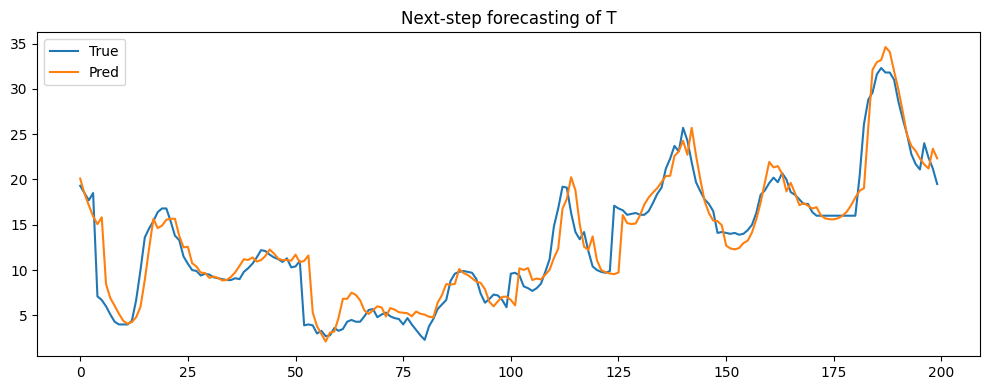

In [11]:
def rmse(a, b):
    return math.sqrt(np.mean((a - b) ** 2))

model.eval()
preds_s, trues_s = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds_s.append(pred)
        trues_s.append(yb.numpy())

preds_s = np.vstack(preds_s)
trues_s = np.vstack(trues_s)

# 역변환(표준화 복원)
preds = y_scaler.inverse_transform(preds_s)
trues = y_scaler.inverse_transform(trues_s)

mae = np.mean(np.abs(preds - trues))
rmse_val = rmse(preds, trues)

print(f"[TEST] MAE={mae:.4f}  RMSE={rmse_val:.4f}  (target: next {target_col})")

# 앞부분 200개만 그려보기
n_show = min(200, len(preds))
plt.figure()
plt.plot(trues[:n_show], label="True")
plt.plot(preds[:n_show], label="Pred")
plt.title(f"Next-step forecasting of {target_col}")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# 테스트 구간의 마지막 seq_len 구간으로 다음 시점 1-step 예측
# (주의: 여기선 학습/검증/테스트 분리 때 생성된 시퀀스 인덱스를 그대로 쓰진 않습니다.)
last_window = X_test_s[-seq_len:]               # (L, F)
last_window_t = torch.from_numpy(last_window).float().unsqueeze(0).to(device)  # (1, L, F)
with torch.no_grad():
    pred_next_s = model(last_window_t).cpu().numpy()
pred_next = y_scaler.inverse_transform(pred_next_s.reshape(-1, 1))[0, 0]
print(f"예상 다음 {target_col}: {pred_next:.3f}")


예상 다음 T: 8.016
